In [1]:
import os
os.chdir('../')

# Analysis to explain where the high cost comes from and changes for NO and NO2 when sparsifying the optimized PV

In [2]:
from utils import *
from loader import *
from PCAfold import feature_size_map
from scipy.signal import find_peaks
from matplotlib.lines import Line2D
from matplotlib import cm
from PCAfold.preprocess import center_scale
from PCAfold import variable_bins
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
logging.disable(logging.CRITICAL)

In [3]:
def compute_avg(costs):
    n = len(costs)
    sum = np.sum(costs**2)
    return 1/n*np.sqrt(sum)

filename_model = "Xu-AE-opt_adam-epo_100000-lr_0.025-date_24Mar2025-hour_10h50_Tr0D-2s_s2"

dataset_type = "autoignition"
path_data = "data-files/"
path_state = path_data + f"Xu-state-space-{dataset_type}.csv"
filename_metadata = filename_model + "_metadata.pkl"
filename_species_names = "Xu-state-space-names.csv"
path_metadata = "metadata/"

penalty_function = 'log-sigma-over-peak'
start_bw = -6
end_bw = 2
nbr_points_bw = 100
bandwidth_values = np.logspace(start_bw, end_bw, nbr_points_bw)
power = 4
vertical_shift = 1
sample_norm_var = False
sample_norm_range = False

nbr_species_compute = 2

my_seed = 7

loader = loadData(filename_species_names, path_metadata, filename_metadata)
output_idx = [1, 2, 3, 5, 10, 15, 16, 18, 19]
idx_species_removed = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"].startswith("autoignition_augm") else loader.metadata["idx species removed"]
input_scaling = loader.metadata["input scaling"]
input_species_scaling = loader.metadata["input species scaling"]
input_species_bias = loader.metadata["input species bias"]
range_mf  = loader.metadata["range_mf"]
depvar_names_species = ['H2O2', 'H2O', 'H2', 'HO2', 'N2O', 'NO2', 'NO', 'O2', 'OH'] #loader.metadata["list species output"]
depvar_names_idx = loader.metadata["output idx Kreg"] if loader.metadata["dataset_type"].startswith("autoignition_augm") else loader.metadata["output elements"]
if(loader.metadata["dataset_type"].startswith("autoignition_augm")):
        if(loader.metadata["Temperature at output"]):
            depvar_names_idx.append("T")
        for i in range(1,1+loader.metadata["PV dim"]):
            depvar_names_idx.append(f"PV{i}")
PV_dim = loader.metadata["PV dim"]
depvar_names = depvar_names_species + depvar_names_idx[-(PV_dim+1):]
model = loader.loadModel()
id = loader.metadata["Training_id"]
nbr_input_species = loader.metadata["nbr input species"]

species = Species(path_data)
list_all_species = species.get_list_species()
list_input_species = [item for idx, item in enumerate(list_all_species) if idx not in idx_species_removed]
print(list_input_species)

cost_array = []
costPV_array = []

costsQoIs_array = []

order_species_removed = []
model = loader.loadModel()

for i in range(nbr_input_species): #nbr_input_species):

    #Update the model with the threshold
    final_weights = model.get_total_encoder_weights(npy = True)

    #get index spcies removed
    my_species = Species(path_data)
    
    list_species = my_species.get_list_species()
    for index in sorted(idx_species_removed, reverse=True):
        list_species.pop(index)

    #get mass fractions of species
    state_space = read_csv(path_state) #header None for low dataset
    state_space = state_space.drop(state_space.columns[idx_species_removed], axis=1)
    state_space_matrix = state_space.to_numpy()

    wi_Yi = state_space_matrix*np.abs(final_weights) #|w_i|*Y_i
    max_wi_Yi = np.max(wi_Yi, axis = 0) #take max of every species

    #selection of values greater than zero
    #CHECK that none of the weights in the PV is already zero!
    mask = max_wi_Yi > 0

    #Find the index with the minimum max wi Yi which is not zero
    index_species_min_max_wi_Yi = np.argmin(max_wi_Yi[mask])

    #Get the index back in the original array
    index_species_min_max_wi_Yi = np.where(mask)[0][index_species_min_max_wi_Yi]
    
    if(i>0): #do not simplify for the first iteration to have the first value with all input species
        with torch.no_grad():
            model.encoder_species.weight[0,index_species_min_max_wi_Yi] = 0
            order_species_removed.append(list_input_species[index_species_min_max_wi_Yi])

    if(nbr_input_species - i <= nbr_species_compute):
        print(i)
        print(model.encoder_species.weight.detach().numpy())
        ##########################
        #Compute the manifold cost
        ##########################
        
        #get the input (PV and f) and the output (interested Yi, T and source terms) data
        input, output = get_dataset(path_data + f"Xu-state-space-{dataset_type}.csv", path_data + f"Xu-state-space_source-{dataset_type}.csv",
                                    path_data + f"Xu-T-{dataset_type}.csv", path_data + f"Xu-mf-{dataset_type}.csv", output_idx, idx_species_removed, input_scaling, input_species_scaling, input_species_bias, range_mf)
        

        PV = model.get_PV(input)
        PV_f = torch.cat((PV, input[:, -1].reshape(-1, 1)), dim = 1) #reshape to be (5200,1) instead of (52000)
        output = model.get_source_PV(output, input_species_scaling)

        #scale every column of the PV_f tensor between 0 and 1
        min_vals = PV_f.min(dim=0, keepdim=True).values
        max_vals = PV_f.max(dim=0, keepdim=True).values
        PV_f_scaled = (PV_f - min_vals) / (max_vals - min_vals)

        if(nbr_input_species - i == 2):
            PV_f_opt2 = PV_f_scaled
        elif(nbr_input_species - i == 1):
            PV_f_opt1 = PV_f_scaled

['H2NN', 'H2O2', 'H2O', 'H2', 'HNO', 'HO2', 'HONO2', 'HONO', 'H', 'N2O', 'NH2', 'NH', 'NNH', 'NO2', 'NO', 'N', 'O2', 'OH', 'O']
17
[[  0.           0.           5.83405763   0.           0.
  136.89436503   0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.        ]]
18
[[0.         0.         5.83405763 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]]


In [4]:
path_variance = "paper/data/"

use_variance = True
type_sample = "-sample-norm-var" if use_variance else "-sample-norm-range" #"sample-norm-var"

name_optimized1 = f"variance_Tr0D-2s_s2-bw_-6_2_100-dataset_autoignition-speciesLeft_1-{type_sample}.npy" #"variance_Tr35a_s3-bw_-6_2_100.npy"
name_optimized2 = f"variance_Tr0D-2s_s2-bw_-6_2_100-dataset_autoignition-speciesLeft_2-{type_sample}.npy" #"variance_Xu-bw_-6_2_100-dataset_low.npy"

penalty_function = 'log-sigma-over-peak'
power = 4
vertical_shift = 1

keys = ['H2O2', 'H2O', 'H2', 'HO2', 'N2O', 'NO2', 'NO', 'O2', 'OH', 'T', 'PV1']

variance_optimized1 = np.load(f"{path_variance}{name_optimized1}", allow_pickle=True).item()
variance_optimized2 = np.load(f"{path_variance}{name_optimized2}", allow_pickle=True).item()

(derivative_optimized1, bandwidth_values_optimized1, max_derivative_optimized1) = normalized_variance_derivative(variance_optimized1)
(derivative_optimized2, bandwidth_values_optimized2, max_derivative_optimized2) = normalized_variance_derivative(variance_optimized2)

costsoptimized1 = cost_function_normalized_variance_derivative(variance_optimized1,
                                                            penalty_function=penalty_function,
                                                            power=power,
                                                            vertical_shift=vertical_shift,
                                                            norm=None)
costsoptimized2 = cost_function_normalized_variance_derivative(variance_optimized2,
                                                            penalty_function=penalty_function,
                                                            power=power,
                                                            vertical_shift=vertical_shift,
                                                            norm=None)

In [5]:
feature_size_map_opt2 = feature_size_map(variance_optimized2,
                                    variable_name='NO',
                                    cutoff=1,
                                    starting_bandwidth_idx='peak',
                                    use_variance=use_variance,
                                    verbose=True)

feature_size_map_opt1 = feature_size_map(variance_optimized1,
                                    variable_name='NO',
                                    cutoff=1,
                                    starting_bandwidth_idx='peak',
                                    use_variance=use_variance,
                                    verbose=True)

Rightmost peak at index 69 is used as the starting bandwidth.

Feature sizes will be computed starting from size:
0.45348785081285914
where the normalized variance derivative is equal to:
0.47852543321576746
Rightmost peak at index 72 is used as the starting bandwidth.

Feature sizes will be computed starting from size:
0.7924828983539186
where the normalized variance derivative is equal to:
0.3768373002178729


## Visualize the feature maps

These maps indicate where small feature sizes are present and where does the highest cost comes from

Rightmost peak at index 69 is used as the starting bandwidth.

Feature sizes will be computed starting from size:
0.45348785081285914
where the normalized variance derivative is equal to:
0.47852543321576746
Rightmost peak at index 72 is used as the starting bandwidth.

Feature sizes will be computed starting from size:
0.7924828983539186
where the normalized variance derivative is equal to:
0.3768373002178729


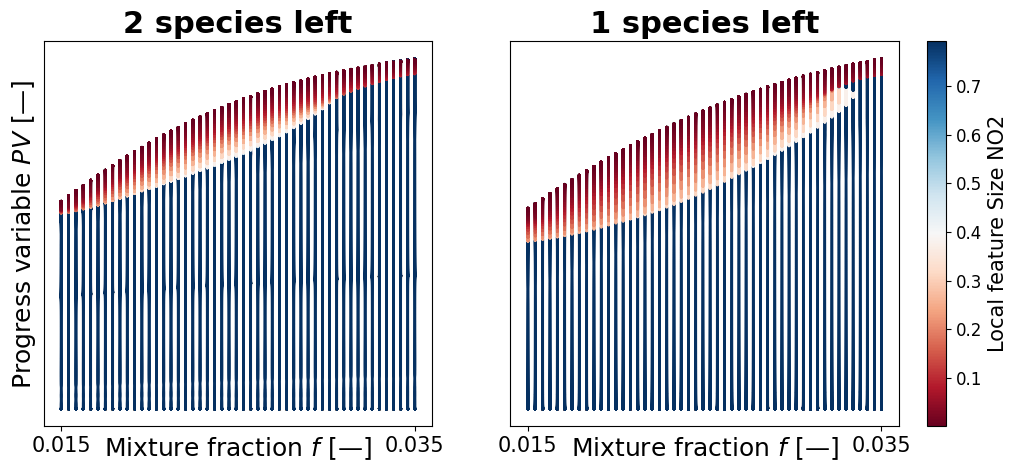

In [6]:
save = True
species = "NO2"
cutoff = 1

pathSave = "C:/Users/Admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/Supplementary-material/Analysis-sparse/"
name = f"f-PV manifolds - feature size map - rightmost peak {type_sample} - {species} - cutoff {cutoff}"

fig, axes = plt.subplots(1, 2, figsize=(12, 5))



feature_size_map_opt2 = feature_size_map(variance_optimized2,
                                    variable_name='NO',
                                    cutoff=cutoff,
                                    starting_bandwidth_idx='peak',
                                    use_variance=use_variance,
                                    verbose=True)

feature_size_map_opt1 = feature_size_map(variance_optimized1,
                                    variable_name='NO',
                                    cutoff=cutoff,
                                    starting_bandwidth_idx='peak',
                                    use_variance=use_variance,
                                    verbose=True)

# --- First subplot ---
sc1 = axes[0].scatter(PV_f_opt2[:, 1].detach().numpy(), PV_f_opt2[:, 0].detach().numpy(), s=1, c=feature_size_map_opt2, cmap='RdBu')
axes[0].set_xlabel("Mixture fraction $f$ [—]", fontsize=18, labelpad = -15)
axes[0].set_ylabel("Progress variable $PV$ [—]", fontsize=18)
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(["0.015", "0.035"])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].set_yticks([])
axes[0].set_title("2 species left", fontsize = 22, fontweight = "bold")

# --- Second subplot ---
sc2 = axes[1].scatter(PV_f_opt1[:, 1].detach().numpy(), PV_f_opt1[:, 0].detach().numpy(), s=1, c=feature_size_map_opt1, cmap='RdBu')
axes[1].set_xlabel("Mixture fraction $f$ [—]", fontsize=18, labelpad = -15)
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(["0.015", "0.035"])
axes[1].tick_params(axis='x', labelsize=15)
axes[1].set_yticks([])
axes[1].set_title("1 species left", fontsize = 22, fontweight = "bold")

cbar = fig.colorbar(sc2, ax=axes, orientation='vertical', fraction=0.05, pad=0.03)
cbar.set_label(f"Local feature Size {species}", fontsize=15)
cbar.ax.tick_params(labelsize=12)

#plt.tight_layout()
if save:
    plt.savefig(pathSave + name + ".png", dpi=300, bbox_inches='tight')
plt.show()

Highest costs are present at the top of the manifold where NO and NO2 have the highest mass fractions

In [7]:
def compute_derivative_penalized(derivative, sigma, variables, rightmost_peak_shift = None):

    derivative_penalized = []

    for variable in variables:
        idx_peaks, _ = find_peaks(derivative[variable], height=0)
        idx_rightmost_peak = idx_peaks[-1]
        rightmost_peak_location = sigma[idx_rightmost_peak]

        if rightmost_peak_shift is not None:
            rightmost_peak_location = rightmost_peak_location + rightmost_peak_shift/100 * (sigma[-1] - rightmost_peak_location)

        normalized_sigma, _, _ = center_scale(np.log10(sigma[:,None]), scaling='0to1')
        addition = normalized_sigma[idx_rightmost_peak][0]
        penalty_log_sigma_peak = (abs(np.log10(sigma/rightmost_peak_location)))**power + vertical_shift * 1. / addition
        derivative_penalized.append(derivative[variable]*penalty_log_sigma_peak)

    return derivative_penalized

C:\Windows\Temp\ipykernel_25864\720976499.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')


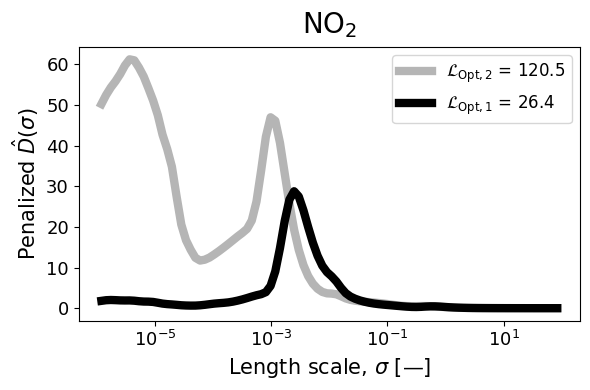

In [19]:
save = True
species = "NO2"
selected_keys = [species]
pathSave = "C:/Users/Admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/Supplementary-material/Analysis-sparse/"
name = f"Detection of different peaks in Dhat - sparse 2 or 1 species left - {species}.png"

# --- Compute Penalized Derivatives ---
greys = cm.get_cmap('Greys')



derivative_optimized1_penalized = compute_derivative_penalized(
    derivative_optimized1, bandwidth_values_optimized1, selected_keys
)
derivative_optimized2_penalized = compute_derivative_penalized(
    derivative_optimized2, bandwidth_values_optimized2, selected_keys
)

# --- Plot Only Penalized Dhat ---
fig, ax = plt.subplots(figsize=(6, 4))

for i, key in enumerate(selected_keys):
    idxcost = keys.index(key)

    # Plot heuristic curve
    lineHeu, = ax.plot(
        bandwidth_values_optimized2,
        derivative_optimized2_penalized[i],
        label=rf'$\mathcal{{L}}_{{\mathrm{{Opt,2}}}}$ = {costsoptimized2[idxcost]:.1f}',
        color=greys(0.4),
        linewidth=6,
        linestyle="-"
    )

    # Plot optimized curve
    lineOpt, = ax.plot(
        bandwidth_values_optimized1,
        derivative_optimized1_penalized[i],
        label=rf'$\mathcal{{L}}_{{\mathrm{{Opt,1}}}}$ = {costsoptimized1[idxcost]:.1f}',
        color=greys(1.0),
        linewidth=6
    )

# --- Formatting ---
ax.set_xscale("log")
ax.set_xlabel(r"Length scale, $\sigma$ [—]", fontsize=15)
ax.set_ylabel(r"Penalized $\hat{D}(\sigma)$", fontsize=15)
ax.tick_params(axis="both", labelsize=13)

# Legend
legend_handles = [
    Line2D([], [], color=greys(0.4), linewidth=6, linestyle="-",
           label=rf'$\mathcal{{L}}_{{\mathrm{{Opt,2}}}}$ = {costsoptimized2[idxcost]:.1f}'),
    Line2D([], [], color=greys(1.0), linewidth=6,
           label=rf'$\mathcal{{L}}_{{\mathrm{{Opt,1}}}}$ = {costsoptimized1[idxcost]:.1f}')
]
ax.legend(handles=legend_handles, fontsize=12)

# Title
key_label = selected_keys[0].replace("2", "$_{2}$").replace("1", "$_{source}$")
ax.set_title(rf"{key_label}", fontsize=20, pad=10)

plt.tight_layout()

# --- Save / Show ---
if save:
    plt.savefig(f"{pathSave}{name}", dpi=300, bbox_inches="tight")

plt.show()

#### Select one trajectory in the middle of the manifold, here with a mixture fraction = 0.4336, and look how NO varies over the PV

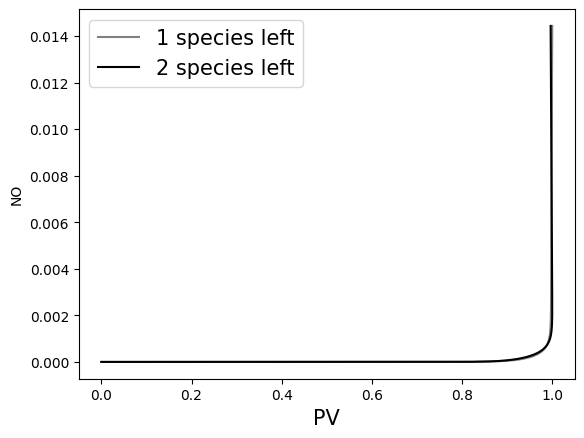

In [10]:
mask = torch.isclose(
    PV_f_opt1[:, 1],
    torch.tensor(0.4336, device=PV_f_opt1.device, dtype=PV_f_opt1.dtype),
    atol=1e-6
)

PV1 = PV_f_opt1[mask, 0].detach().numpy()
PV1 = (PV1 - PV1.min())/(PV1.max() - PV1.min())

PV2 = PV_f_opt2[mask, 0].detach().numpy()
PV2 = (PV2 - PV2.min())/(PV2.max() - PV2.min())

plt.plot(PV1, output[mask, 6].detach().numpy(), color = "grey", label = "1 species left")
plt.plot(PV2, output[mask, 6].detach().numpy(), color = "k", label = "2 species left")
plt.xlabel("PV", fontsize = 15)
plt.ylabel("NO")
plt.legend(fontsize = 15)
plt.show()

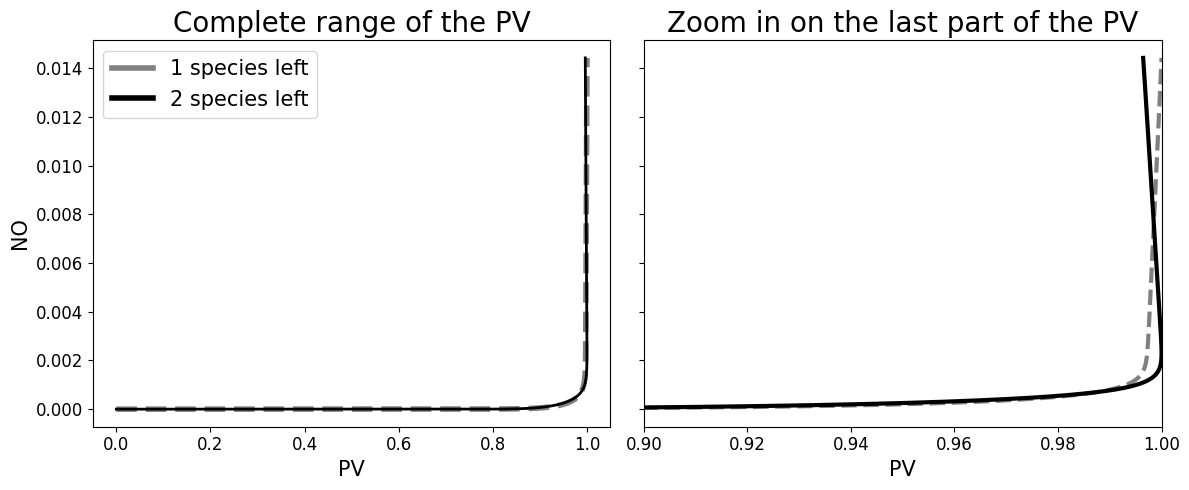

In [13]:
save = False
species = "NO"
selected_keys = [species]
pathSave = "C:/Users/Admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/Supplementary-material/Analysis-sparse/"
name = f"Comparison one PV trajectory - mf = 0.4336 - sparse 2 or 1 species left - {species}.png"

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# ---------- Left plot (unchanged) ----------
axes[0].plot(PV1, output[mask, 6].detach().numpy(), color="grey", label="1 species left", lw = 4, linestyle = "--")
axes[0].plot(PV2, output[mask, 6].detach().numpy(), color="k", label="2 species left", lw = 2)
axes[0].set_xlabel("PV", fontsize=15)
axes[0].set_ylabel("NO", fontsize=15)
axes[0].tick_params(axis='both', labelsize=12)
axes[0].set_title("Complete range of the PV", fontsize = 20)

# ---------- Right plot (zoomed) ----------
axes[1].plot(PV1, output[mask, 6].detach().numpy(), color="grey", lw = 3, linestyle = "--")
axes[1].plot(PV2, output[mask, 6].detach().numpy(), color="k", lw = 3)
axes[1].set_xlim(0.9, 1.0)
axes[1].set_xlabel("PV", fontsize=15)
axes[1].tick_params(axis='both', labelsize=12)
axes[1].set_title("Zoom in on the last part of the PV", fontsize = 20)

legend_lines = [
    Line2D([0], [0], color="grey", lw=4),
    Line2D([0], [0], color="k", lw=4)
]

axes[0].legend(
    legend_lines,
    ["1 species left", "2 species left"],
    fontsize=15
)

plt.tight_layout()

if save:
    plt.savefig(f"{pathSave}{name}", dpi=300, bbox_inches="tight")

plt.show()

When 2 species are remaining in the optimized PV definition, the PV is non-unique between 0.995 and 1 explaining the higher cost